<a href="https://colab.research.google.com/github/ThaliSouza2017/analise_exploratoria/blob/master/LSTM_Network_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utilizando LSTM Network para predição de manutenção de equipamentos

##Part 1 - Data Preparation
* Importando bibliotecas
* Fazendo upload de arquivo
* Renomeando colunas
* Verificando a existência de valores ausentes 
* Entendendo a composição do dataset, com análise exploratória

In [0]:
# Importando bibliotecas:
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Fazendo upload das bases
from google.colab import files
uploaded = files.upload()

Saving PM_test1.txt to PM_test1.txt
Saving PM_trai1.txt to PM_trai1.txt


In [0]:
#Criando o dataset de teste a partir do arquivo
with open('PM_test1.txt', 'r') as f:
    df_test = pd.read_table(f, sep='\s+')

In [308]:
df_test.head(2)

1  1.1  0.0023  0.0003  100.0  ...  392  2388  100.00  38.86  23.3735
0  1    2 -0.0027 -0.0003  100.0  ...  393  2388   100.0  39.02  23.3916
1  1    3  0.0003  0.0001  100.0  ...  393  2388   100.0  39.08  23.4166

[2 rows x 26 columns]

In [0]:
#Criando nomes das colunas conforme documentação
df_test.columns = ["asset_id","runtime","setting1","setting2","setting3","tag1","tag2","tag3","tag4","tag5","tag6","tag7","tag8","tag9","tag10","tag11","tag12","tag13","tag14","tag15","tag16","tag17","tag18","tag19","tag20","tag21"]


In [0]:
#Criando o dataset de treino a partir do arquivo
with open('PM_trai1.txt', 'r') as f:
    df_train = pd.read_table(f, sep='\s+')

In [311]:
#Exibindo as primeiras colunas do dataset
df_train.head(10)
#df_test.head(10)

1  1.1  -0.0007  -0.0004  100.0  ...  392  2388  100.00  39.06  23.4190
0  1    2   0.0019  -0.0003  100.0  ...  392  2388   100.0  39.00  23.4236
1  1    3  -0.0043   0.0003  100.0  ...  390  2388   100.0  38.95  23.3442
2  1    4   0.0007   0.0000  100.0  ...  392  2388   100.0  38.88  23.3739
3  1    5  -0.0019  -0.0002  100.0  ...  393  2388   100.0  38.90  23.4044
4  1    6  -0.0043  -0.0001  100.0  ...  391  2388   100.0  38.98  23.3669
5  1    7   0.0010   0.0001  100.0  ...  392  2388   100.0  39.10  23.3774
6  1    8  -0.0034   0.0003  100.0  ...  391  2388   100.0  38.97  23.3106
7  1    9   0.0008   0.0001  100.0  ...  392  2388   100.0  39.05  23.4066
8  1   10  -0.0033   0.0001  100.0  ...  393  2388   100.0  38.95  23.4694
9  1   11   0.0018  -0.0003  100.0  ...  392  2388   100.0  38.94  23.4787

[10 rows x 26 columns]

In [312]:
#Verificando a existência de dados faltantes em abos datasets
#df_test.isna().sum()
df_train.isna().sum()

1          0
1.1        0
-0.0007    0
-0.0004    0
100.0      0
518.67     0
641.82     0
1589.70    0
1400.60    0
14.62      0
21.61      0
554.36     0
2388.06    0
9046.19    0
1.30       0
47.47      0
521.66     0
2388.02    0
8138.62    0
8.4195     0
0.03       0
392        0
2388       0
100.00     0
39.06      0
23.4190    0
dtype: int64

In [0]:
#Criando nomes das colunas conforme documentação
df_train.columns = ["asset_id","runtime","setting1","setting2","setting3","tag1","tag2","tag3","tag4","tag5","tag6","tag7","tag8","tag9","tag10","tag11","tag12","tag13","tag14","tag15","tag16","tag17","tag18","tag19","tag20","tag21"]


In [314]:
#Descrevendo o dataset de treino
df_train.describe().T

count         mean           std  ...         50%        75%        max
asset_id  20630.0    51.509016  2.922623e+01  ...    52.00000    77.0000   100.0000
runtime   20630.0   108.813088  6.887857e+01  ...   104.00000   156.0000   362.0000
setting1  20630.0    -0.000009  2.187361e-03  ...     0.00000     0.0015     0.0087
setting2  20630.0     0.000002  2.930558e-04  ...     0.00000     0.0003     0.0006
setting3  20630.0   100.000000  0.000000e+00  ...   100.00000   100.0000   100.0000
tag1      20630.0   518.670000  6.537152e-11  ...   518.67000   518.6700   518.6700
tag2      20630.0   642.680975  5.000295e-01  ...   642.64000   643.0000   644.5300
tag3      20630.0  1590.523159  6.131295e+00  ...  1590.10000  1594.3800  1616.9100
tag4      20630.0  1408.934186  9.000636e+00  ...  1408.04000  1414.5575  1441.4900
tag5      20630.0    14.620000  3.394700e-12  ...    14.62000    14.6200    14.6200
tag6      20630.0    21.609803  1.389018e-03  ...    21.61000    21.6100    21.6100
tag7      20630.0   553.367663  8.850867e-01  ...   553.44000   554.0100   556.0600
tag8      20630.0  2388.096653  7.098674e-02  ...  2388.09000  2388.1400  2388.5600
tag9      20630.0  9065.243864  2.208302e+01  ...  9060.66000  9069.4200  9244.5900
tag10     20630.0     1.300000  4.660829e-13  ...     1.30000     1.3000     1.3000
tag11     20630.0    47.541172  2.670934e-01  ...    47.51000    47.7000    48.5300
tag12     20630.0   521.413458  7.375693e-01  ...   521.48000   521.9500   523.3800
tag13     20630.0  2388.096156  7.191870e-02  ...  2388.09000  2388.1400  2388.5600
tag14     20630.0  8143.752971  1.907660e+01  ...  8140.54000  8148.3100  8293.7200
tag15     20630.0     8.442147  3.750562e-02  ...     8.43895     8.4656     8.5848
tag16     20630.0     0.030000  1.556432e-14  ...     0.03000     0.0300     0.0300
tag17     20630.0   393.210713  1.548778e+00  ...   393.00000   394.0000   400.0000
tag18     20630.0  2388.000000  0.000000e+00  ...  2388.00000  2388.0000  2388.0000
tag19     20630.0   100.000000  0.000000e+00  ...   100.00000   100.0000   100.0000
tag20     20630.0    38.816259  1.807428e-01  ...    38.83000    38.9500    39.4300
tag21     20630.0    23.289699  1.082498e-01  ...    23.29790    23.3668    23.6184

[26 rows x 8 columns]

In [315]:
#Verificando a existência de valores únicos em cada coluna
df_train.nunique()

asset_id     100
runtime      362
setting1     158
setting2      13
setting3       1
tag1           1
tag2         310
tag3        3012
tag4        4051
tag5           1
tag6           2
tag7         513
tag8          53
tag9        6403
tag10          1
tag11        159
tag12        427
tag13         56
tag14       6078
tag15       1918
tag16          1
tag17         13
tag18          1
tag19          1
tag20        120
tag21       4745
dtype: int64

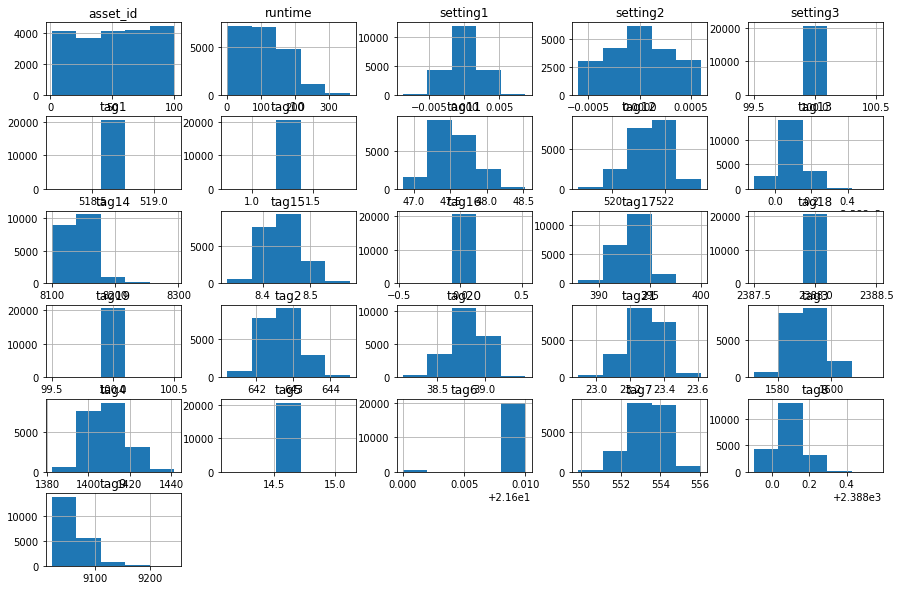

In [316]:
#Plotando histograma básico para visualização da distribuição dos dados
df_train.hist(bins = 5, figsize=(15,10))
plt.show()

In [317]:
#Analisando possíveis correlações entre as variáveis, que devem ser tratadas em alguns modelos, como de Regressão, por exemplo
df_train.corr()

asset_id       runtime  ...         tag20         tag21
asset_id  1.000000e+00  7.863178e-02  ... -2.047800e-02 -1.636683e-02
runtime   7.863178e-02  1.000000e+00  ... -5.835550e-01 -5.858878e-01
setting1 -1.792290e-02 -4.551067e-03  ... -5.692236e-03 -1.454087e-02
setting2 -6.312289e-03  1.602956e-02  ... -1.046523e-02 -7.766692e-03
setting3           NaN           NaN  ...           NaN           NaN
tag1     -1.972032e-13  2.617457e-14  ... -7.190231e-13 -5.975262e-13
tag2      1.399056e-02  5.498396e-01  ... -6.618049e-01 -6.680216e-01
tag3      1.261094e-02  5.439693e-01  ... -6.259605e-01 -6.339152e-01
tag4      2.604071e-02  6.245570e-01  ... -7.480551e-01 -7.451807e-01
tag5     -1.640867e-13 -2.422190e-14  ... -7.160622e-13 -5.974260e-13
tag6      2.644529e-02  1.059971e-01  ... -1.414341e-01 -1.374317e-01
tag7     -3.198195e-02 -5.958820e-01  ...  7.361449e-01  7.374296e-01
tag8      3.988934e-02  4.759695e-01  ... -6.870312e-01 -6.888384e-01
tag9     -5.213027e-02  4.439683e-01  ... -2.852410e-01 -2.927606e-01
tag10     7.135425e-14  1.909932e-14  ... -7.163302e-13 -5.974348e-13
tag11     2.468664e-02  6.344030e-01  ... -7.715275e-01 -7.725671e-01
tag12    -3.185674e-02 -6.113662e-01  ...  7.519564e-01  7.562715e-01
tag13     4.414552e-02  4.774840e-01  ... -6.861520e-01 -6.889289e-01
tag14    -5.950036e-02  3.703259e-01  ... -1.873555e-01 -1.924065e-01
tag15     2.243756e-02  5.886701e-01  ... -7.076695e-01 -7.040385e-01
tag16     1.475669e-13  2.626674e-14  ... -7.155747e-13 -5.974754e-13
tag17     1.344904e-02  5.669777e-01  ... -6.510081e-01 -6.586970e-01
tag18              NaN           NaN  ...           NaN           NaN
tag19              NaN           NaN  ...           NaN           NaN
tag20    -2.047800e-02 -5.835550e-01  ...  1.000000e+00  6.934564e-01
tag21    -1.636683e-02 -5.858878e-01  ...  6.934564e-01  1.000000e+00

[26 rows x 26 columns]

In [318]:
#conferindo a quantidade de valores nos datasets de treino e teste
print('Train: ', df_train.shape, 'Test: ', df_test.shape)

Train:  (20630, 26) Test:  (13095, 26)


## 2 - Calculando o RUL (remaining useful life)

_O cálculo da vida útil restante do ativo foi calculada com base no seu (ciclo máximo - ciclo atual). Esse cálculo foi aplicado em todas as linhas, para garantir a atualização desses valores de acordo com o tempo de vida de cada ativo_


In [319]:
#Verificando qual o máximo de vezes que um asset_id permaneceu ativo antes de falhar
last_runtime_train = df_train.groupby('asset_id')['runtime'].max().reset_index()
last_runtime_train.columns = ['asset_id', 'max_runtime_train']

#Agregando essa nova coluna ao antigo dataset de treino
new_df_train = df_train.merge(last_runtime_train, left_on='asset_id', right_on='asset_id', how='inner')

rul_target = new_df_train['max_runtime_train'] - new_df_train['runtime']
df_train_pred = new_df_train['rul_predict'] = rul_target

new_df_train.head(20)

asset_id  runtime  setting1  ...    tag21  max_runtime_train  rul_predict
0          1        2    0.0019  ...  23.4236                192          190
1          1        3   -0.0043  ...  23.3442                192          189
2          1        4    0.0007  ...  23.3739                192          188
3          1        5   -0.0019  ...  23.4044                192          187
4          1        6   -0.0043  ...  23.3669                192          186
5          1        7    0.0010  ...  23.3774                192          185
6          1        8   -0.0034  ...  23.3106                192          184
7          1        9    0.0008  ...  23.4066                192          183
8          1       10   -0.0033  ...  23.4694                192          182
9          1       11    0.0018  ...  23.4787                192          181
10         1       12    0.0016  ...  23.3660                192          180
11         1       13   -0.0019  ...  23.2757                192          179
12         1       14    0.0009  ...  23.3826                192          178
13         1       15   -0.0018  ...  23.3500                192          177
14         1       16    0.0006  ...  23.4550                192          176
15         1       17    0.0002  ...  23.3319                192          175
16         1       18   -0.0031  ...  23.3987                192          174
17         1       19    0.0032  ...  23.3464                192          173
18         1       20   -0.0037  ...  23.4220                192          172
19         1       21   -0.0012  ...  23.3101                192          171

[20 rows x 28 columns]

In [320]:
new_df_train.head()

asset_id  runtime  setting1  ...    tag21  max_runtime_train  rul_predict
0         1        2    0.0019  ...  23.4236                192          190
1         1        3   -0.0043  ...  23.3442                192          189
2         1        4    0.0007  ...  23.3739                192          188
3         1        5   -0.0019  ...  23.4044                192          187
4         1        6   -0.0043  ...  23.3669                192          186

[5 rows x 28 columns]

In [321]:
#Removendo as colunas desnecessárias
df_train_pred = new_df_train.drop('max_runtime_train', axis=1)
df_train_pred.head()

asset_id  runtime  setting1  setting2  ...  tag19  tag20    tag21  rul_predict
0         1        2    0.0019   -0.0003  ...  100.0  39.00  23.4236          190
1         1        3   -0.0043    0.0003  ...  100.0  38.95  23.3442          189
2         1        4    0.0007    0.0000  ...  100.0  38.88  23.3739          188
3         1        5   -0.0019   -0.0002  ...  100.0  38.90  23.4044          187
4         1        6   -0.0043   -0.0001  ...  100.0  38.98  23.3669          186

[5 rows x 27 columns]

In [322]:
#Repetindo os mesmo passos com o dataset de teste
last_runtime_test = df_test.groupby('asset_id')['runtime'].max().reset_index()
last_runtime_test.columns = ['asset_id', 'max_runtime_test']

new_df_test = df_test.merge(last_runtime_test, left_on='asset_id', right_on='asset_id', how='inner')

rul_target_test = new_df_test['max_runtime_test'] - new_df_test['runtime']
df_test_pred = new_df_test['rul_predict'] = rul_target_test

new_df_test.head()

asset_id  runtime  setting1  ...    tag21  max_runtime_test  rul_predict
0         1        2   -0.0027  ...  23.3916                31           29
1         1        3    0.0003  ...  23.4166                31           28
2         1        4    0.0042  ...  23.3737                31           27
3         1        5    0.0014  ...  23.4130                31           26
4         1        6    0.0012  ...  23.3467                31           25

[5 rows x 28 columns]

In [323]:
# remove unnecessary column
df_test_pred = new_df_test.drop('max_runtime_test', axis=1)
df_test_pred.head(5)

asset_id  runtime  setting1  setting2  ...  tag19  tag20    tag21  rul_predict
0         1        2   -0.0027   -0.0003  ...  100.0  39.02  23.3916           29
1         1        3    0.0003    0.0001  ...  100.0  39.08  23.4166           28
2         1        4    0.0042    0.0000  ...  100.0  39.00  23.3737           27
3         1        5    0.0014    0.0000  ...  100.0  38.99  23.4130           26
4         1        6    0.0012    0.0003  ...  100.0  38.91  23.3467           25

[5 rows x 27 columns]

## 3 - Valores da predição
* Nessa parte, conforme orientação da documentação, quero prever os ativos que possivelmente precisarão de manutenção em até 20 próximos ciclos de utilização

In [324]:
#Com base no RUL de cada ativo, estou classificando cada linha em ativos que quero prever (== 1), e ativos que não quero prever pois possuem RUL acima de 20 (==0)
cycles = 20
df_train_pred['class'] = df_train_pred['rul_predict'].apply(lambda x: 1 if x <= cycles else 0)
df_test_pred['class'] = df_test_pred['rul_predict'].apply(lambda x: 1 if x <= cycles else 0)
#df_train_pred.head()
df_test_pred.head()

asset_id  runtime  setting1  setting2  ...  tag20    tag21  rul_predict  class
0         1        2   -0.0027   -0.0003  ...  39.02  23.3916           29      0
1         1        3    0.0003    0.0001  ...  39.08  23.4166           28      0
2         1        4    0.0042    0.0000  ...  39.00  23.3737           27      0
3         1        5    0.0014    0.0000  ...  38.99  23.4130           26      0
4         1        6    0.0012    0.0003  ...  38.91  23.3467           25      0

[5 rows x 28 columns]

In [0]:
#Separando um dataset para a variável preditora
X_var = df_train_pred['rul_predict']
X_var.head()

0    190
1    189
2    188
3    187
4    186
Name: rul_predict, dtype: int64

In [0]:
sets = ['setting'+str(i) for i in range(1,4)]
tags = ['tag'+str(i) for i in range(1,22)]

In [0]:
y_var1 = df_train.drop(['asset_id','runtime'], axis = 1)
y_var1.head()

setting1  setting2  setting3    tag1  ...  tag18  tag19  tag20    tag21
0    0.0019   -0.0003     100.0  518.67  ...   2388  100.0  39.00  23.4236
1   -0.0043    0.0003     100.0  518.67  ...   2388  100.0  38.95  23.3442
2    0.0007    0.0000     100.0  518.67  ...   2388  100.0  38.88  23.3739
3   -0.0019   -0.0002     100.0  518.67  ...   2388  100.0  38.90  23.4044
4   -0.0043   -0.0001     100.0  518.67  ...   2388  100.0  38.98  23.3669

[5 rows x 24 columns]

Text(0.5, 1.0, 'Performance dos assets - Tag21')

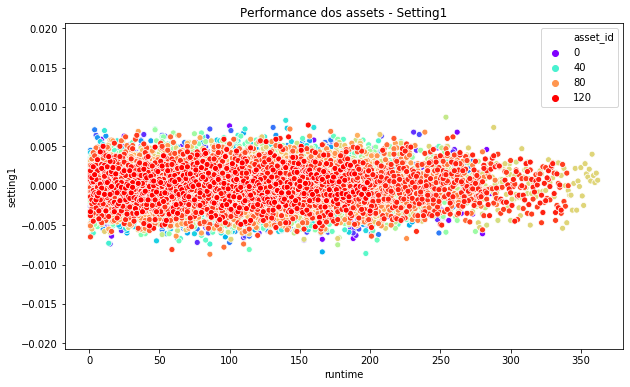

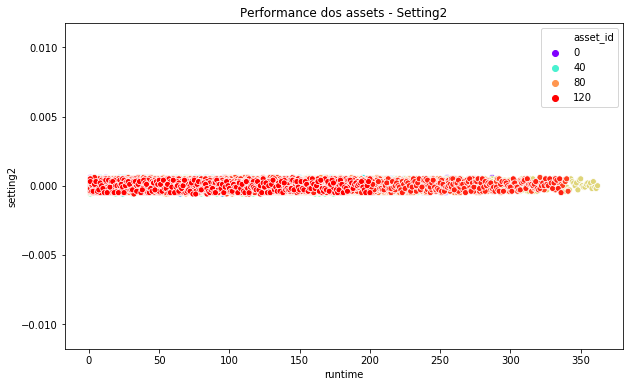

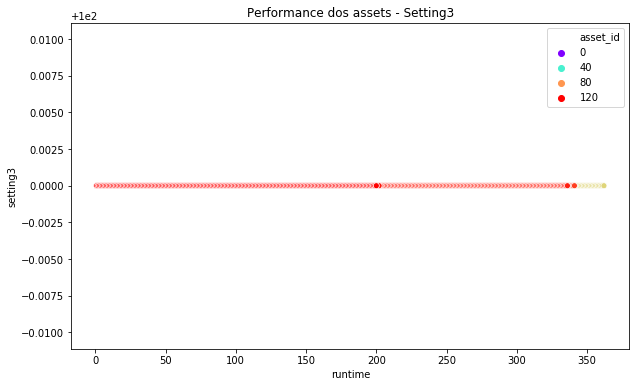

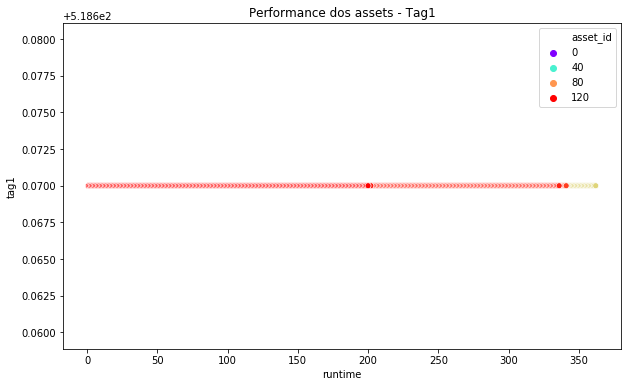

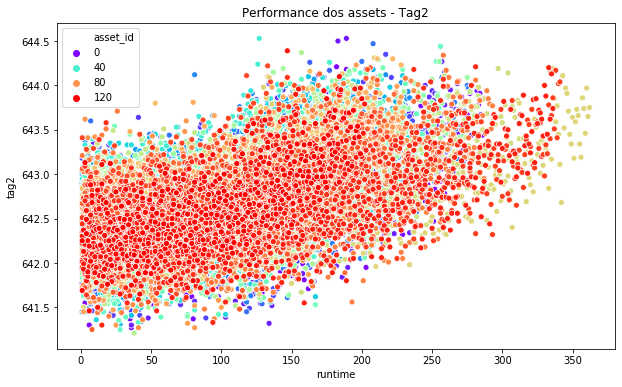

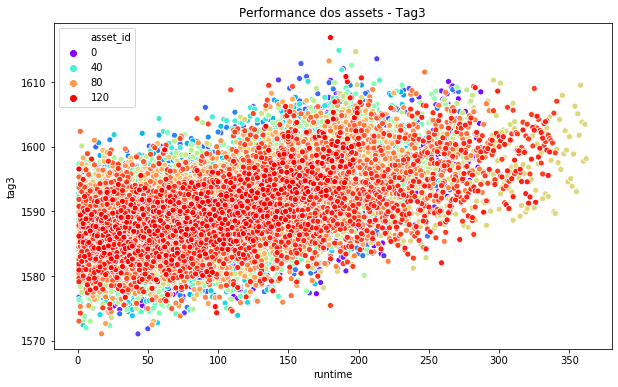

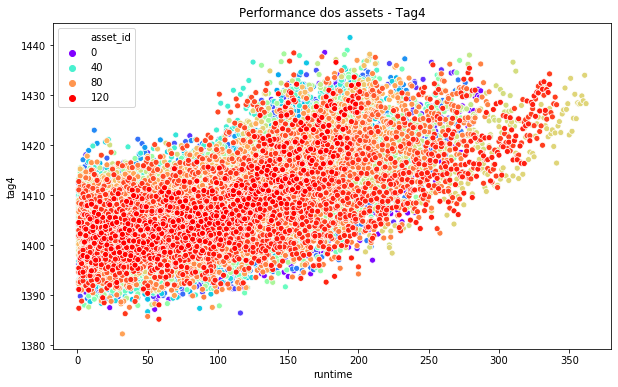

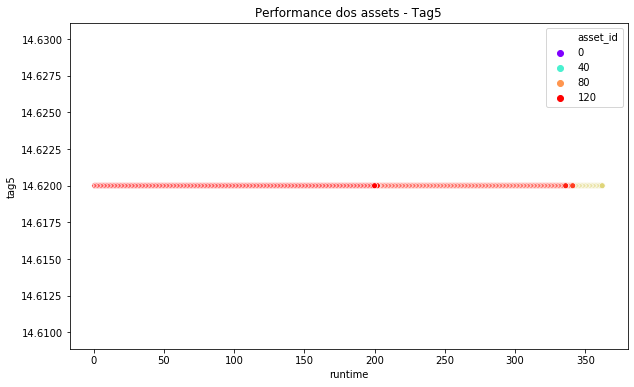

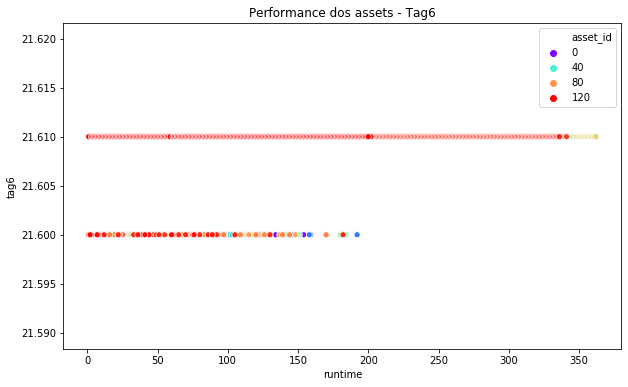

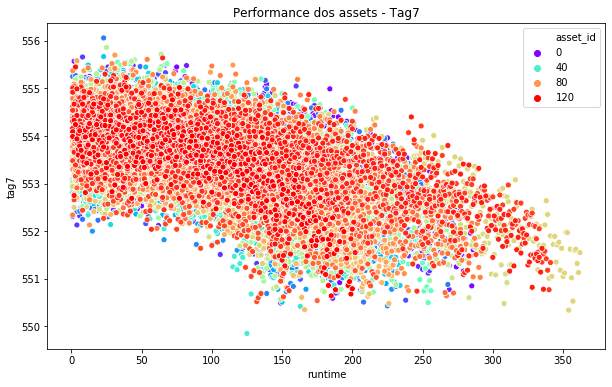

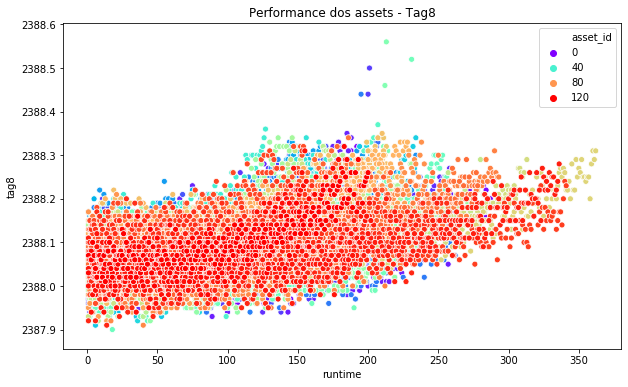

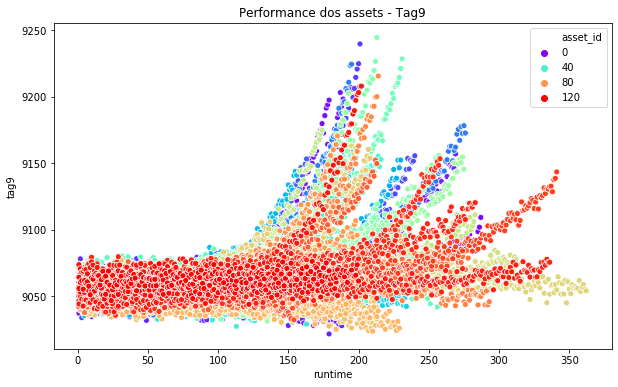

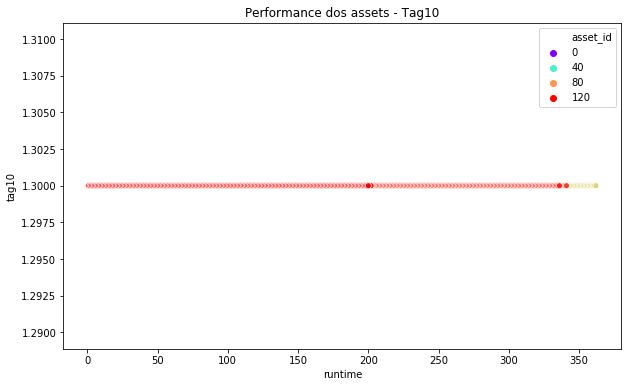

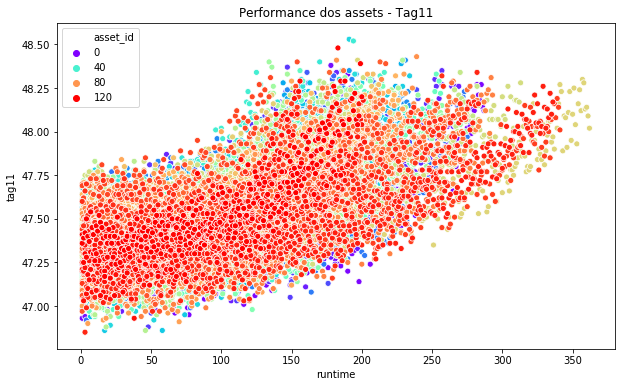

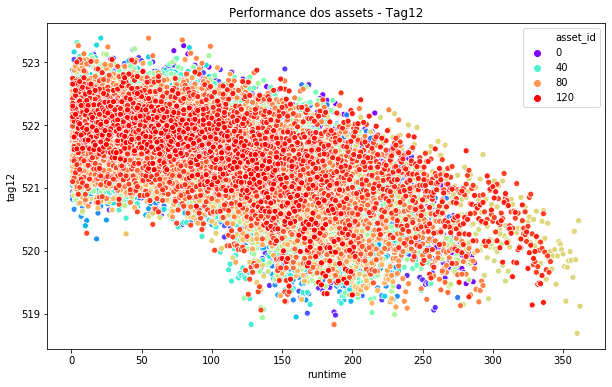

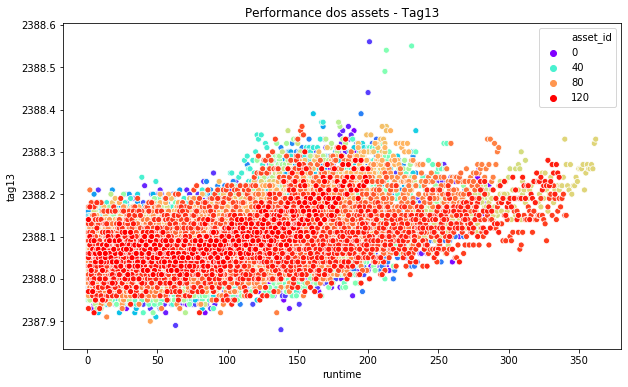

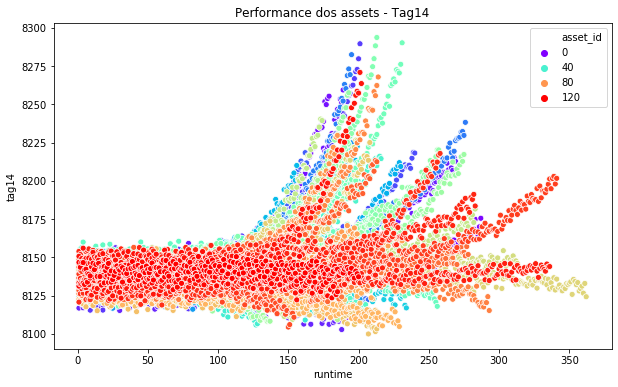

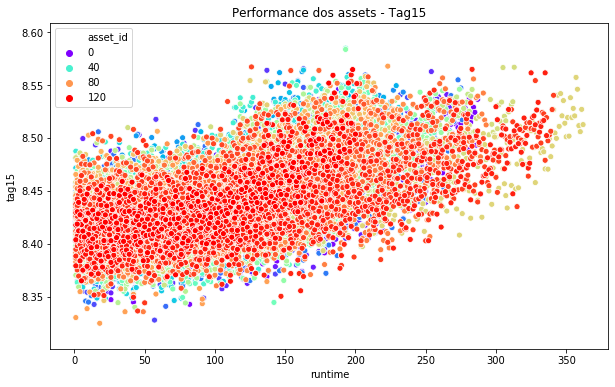

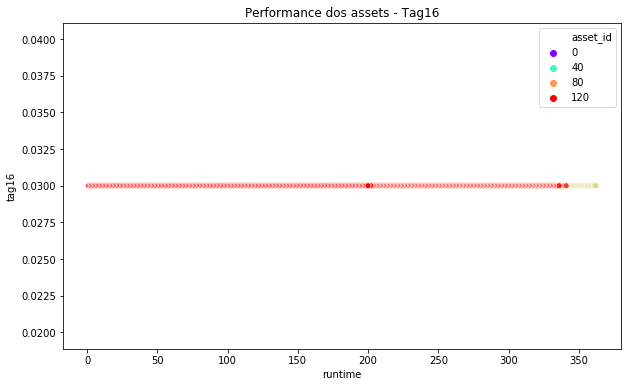

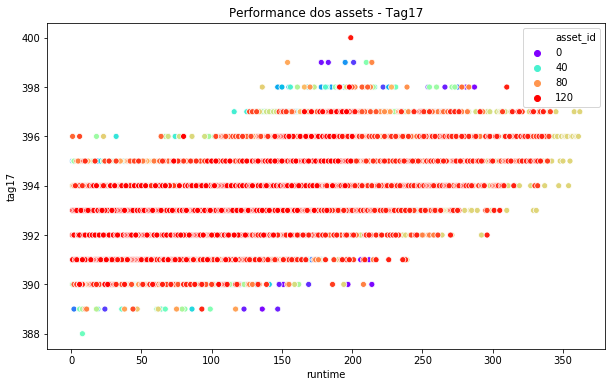

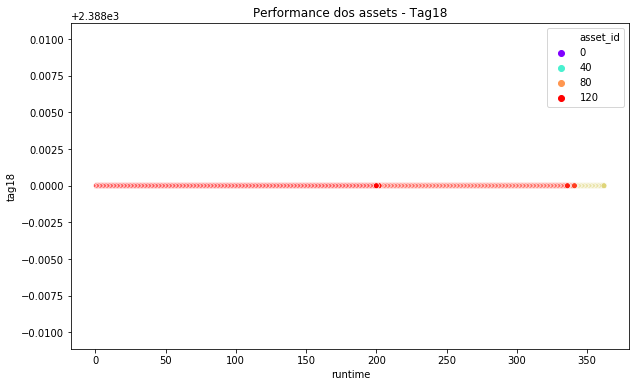

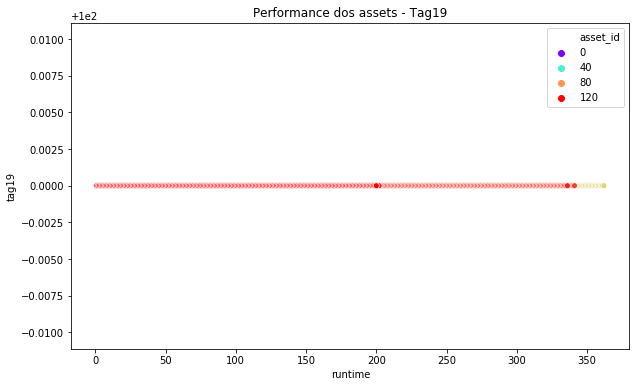

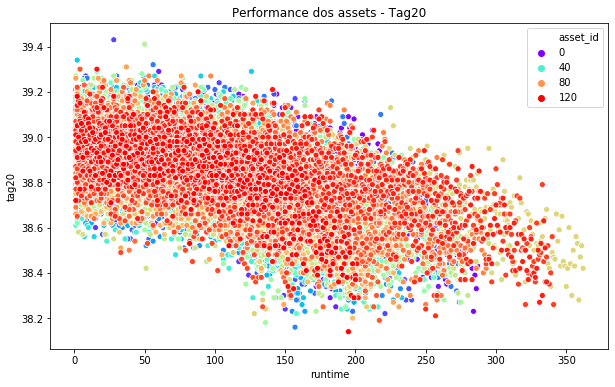

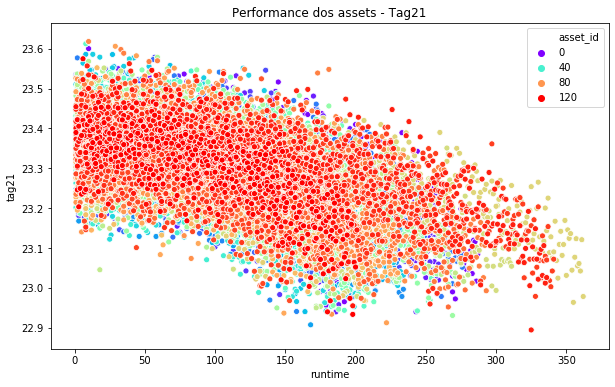

In [325]:
#Plotando os gráficos para observar a performance de cada asset, ao longo dos ciclos de vida
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('setting1'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Setting1')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('setting2'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Setting2')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('setting3'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Setting3')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag1'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag1')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag2'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag2')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag3'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag3')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag4'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag4')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag5'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag5')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag6'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag6')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag7'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag7')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag8'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag8')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag9'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag9')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag10'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag10')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag11'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag11')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag12'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag12')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag13'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag13')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag14'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag14')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag15'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag15')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag16'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag16')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag17'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag17')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag18'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag18')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag19'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag19')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag20'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag20')

plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='runtime',y=('tag21'),data = df_train_pred,palette='rainbow',hue='asset_id')
ax.set_title('Performance dos assets - Tag21')

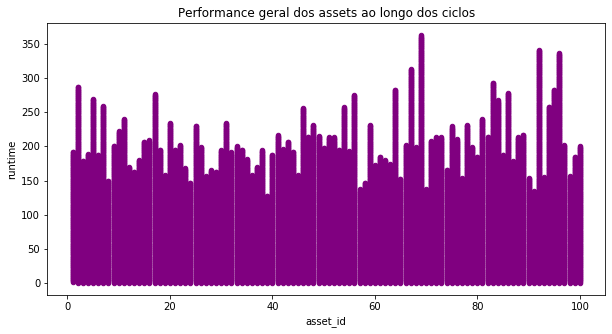

In [326]:
#Quero verificar como está a Performance geral dos meus ativos, comparando-os com os ciclos atuais
df_train_pred.plot('asset_id', 'runtime', kind='scatter',figsize=(10,5), title='Performance geral dos assets ao longo dos ciclos', legend=True, color='purple')
plt.show()

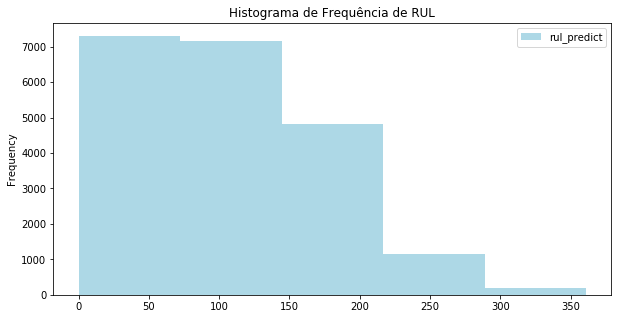

In [327]:
#Visualizando a distribuição dos RUL dos meus ativos
df_train_pred.plot('asset_id', 'rul_predict', kind='hist', bins=5, figsize=(10,5), title='Histograma de Frequência de RUL', legend=True, color='lightblue')
plt.show()

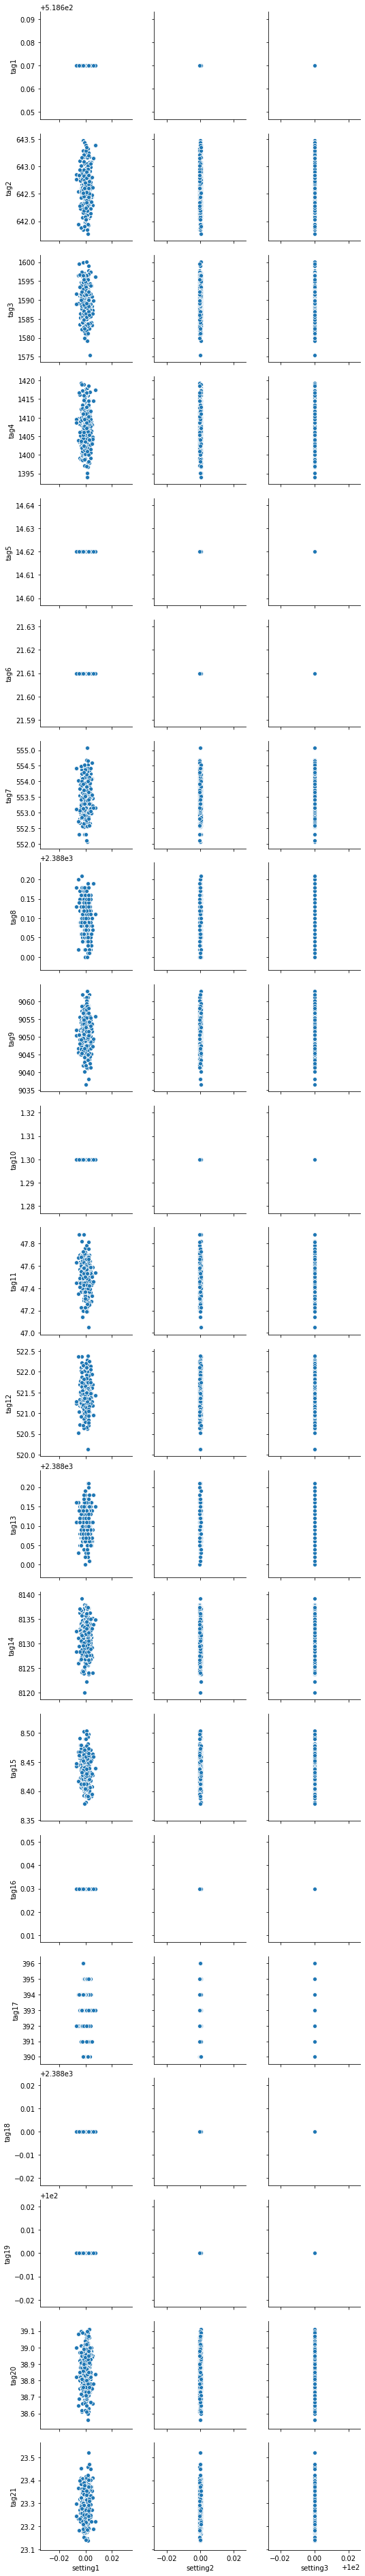

In [328]:
#Visualizando a relação entre ciclos(runtime) com as variáveis setting e tags, que são responsáveis por trazer medições a cada ciclo
sns.pairplot(df_test.query('runtime'),x_vars=sets,y_vars=tags, palette='husl')
#sns.pairplot(df_train.query('runtime'),x_vars=sets,y_vars=tags, palette='husl')

## 4 - Definindo os datasets de treino e teste

* Utilizando RandomForest para seleção de atributos mais importantes
* Visualização dos atributos mais importantes
* Standartização das variáveis antes de rodar o modelo de predição

In [329]:
#Definindo datasets de treino
y_train = df_train_pred['rul_predict']
X_train = df_train_pred.drop(['asset_id', 'runtime', 'rul_predict'], axis = 1)

#Definindo datasets de teste
y_test = df_test_pred['rul_predict']
X_test = df_test_pred.drop(['asset_id', 'runtime', 'rul_predict'], axis = 1)

#Criando um modelo de RandomForest para entendimento de importância das variáveis
from sklearn import ensemble
forest_model = ensemble.RandomForestRegressor()
forest1 = ensemble.RandomForestRegressor(n_estimators = 100, max_depth = 15)
forest1.fit(X_train, y_train)
y_pred = forest1.predict(X_train)
print('ok')

ok


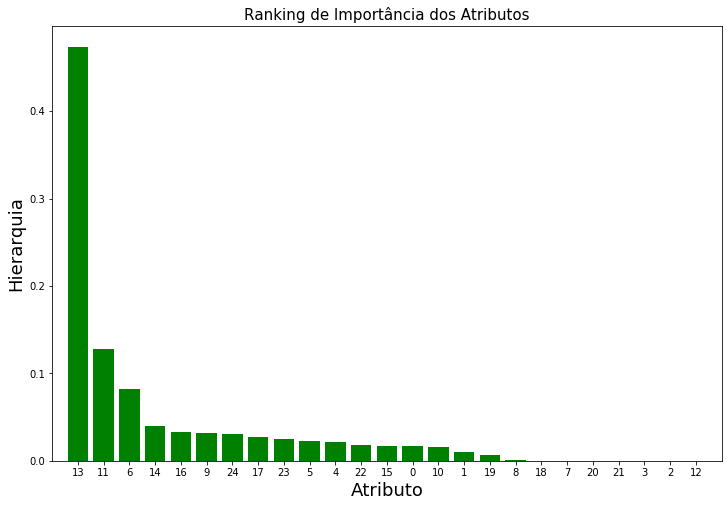

tag11       0.473889
tag9        0.128291
tag4        0.081993
tag12       0.039972
tag14       0.032463
tag7        0.031522
class       0.030792
tag15       0.026935
tag21       0.025499
tag3        0.022308
tag2        0.021256
tag20       0.018280
tag13       0.017072
setting1    0.016568
tag8        0.015889
setting2    0.009563
tag17       0.007187
tag6        0.000522
tag16       0.000000
tag5        0.000000
dtype: float64


In [330]:
# graph feature importance
feature_ranking = forest1.feature_importances_
ind = np.argsort(feature_ranking)[::-1]
feature_names = X_train.columns    
f, ax = plt.subplots(figsize=(12, 8))
plt.title('Ranking de Importância dos Atributos', fontsize = 15)
plt.bar(range(X_train.shape[1]), feature_ranking[ind], color="g", align="center")
plt.xticks(range(X_train.shape[1]), ind)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel('Hierarquia', fontsize = 18)
plt.xlabel('Atributo', fontsize = 18)
plt.show()
# list feature importance
features = pd.Series(data=forest1.feature_importances_,index=X_train.columns)
features.sort_values(ascending=False,inplace=True)
print(features.head(20))

In [331]:
#Hora de standartizar os padrões. Como os datasets não possuem muitos outliers, vou optar por utilizar a StandartScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('ok')


ok


In [332]:
#Verificando as bases após a Standartização
print(standardized_X)

[[ 0.87268757 -1.03180904  0.         ...  1.01661346  1.23699265
  -0.33664482]
 [-1.96184673  1.01563197  0.         ...  0.73997063  0.50348592
  -0.33664482]
 [ 0.32406803 -0.00808853  0.         ...  0.35267067  0.77785808
  -0.33664482]
 ...
 [ 0.18691314 -0.00808853  0.         ... -2.08178626 -3.29245762
   2.97048978]
 [-0.49886128  1.01563197  0.         ... -2.91171476 -2.08503533
   2.97048978]
 [-1.45894548 -1.71428938  0.         ... -2.46908623 -2.19404514
   2.97048978]]


In [333]:
#Exibindo o formato das bases de teste e treino
print('Train: ', X_train.shape, 'Test: ', X_test.shape)

Train:  (20630, 25) Test:  (13095, 25)


In [334]:
print('Train: ', y_train.shape, 'Test: ', y_test.shape)

Train:  (20630,) Test:  (13095,)


In [0]:
#Criando novas variáveis que irão ajudar na modelagem
features_columns = ['setting1', 'setting2', 'setting3', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11',
                   'tag12', 'tag13', 'tag14', 'tag15', 'tag16', 'tag17', 'tag18', 'tag19', 'tag20', 'tag21']
target_columns = 'class'

In [336]:
#Funções preparatórias para aplicação do LSTM Neural Network
#Gerando Sequência
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

#Gerando Labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

seq_length = 50
seq_cols=features_columns

print('ok')

ok


In [338]:
#Incorporando as novas variáveis aos datasets de treino
X_train = np.concatenate(list(list(gen_sequence(df_train_pred[df_train_pred['asset_id']==id], seq_length, seq_cols)) for id in df_train_pred['asset_id'].unique()))
print(X_train.shape)

y_train=np.concatenate(list(list(gen_label(df_train_pred[df_train_pred['asset_id']==id], 50, seq_cols,'class')) for id in df_train_pred['asset_id'].unique()))
print(y_train.shape)

(20530, 50, 24)
(20530,)


In [339]:
#Repetindo o processo com as bases de teste
X_test=np.concatenate(list(list(gen_sequence(df_test_pred[df_test_pred['asset_id']==id], seq_length, seq_cols)) for id in df_test_pred['asset_id'].unique()))
print(X_test.shape)

y_test=np.concatenate(list(list(gen_label(df_test_pred[df_test_pred['asset_id']==id], 50, seq_cols,'class')) for id in df_test_pred['asset_id'].unique()))
print(y_test.shape)

(12995, 50, 24)
(12995,)


## 5 - LSTM Network

 _Pelo que pesquisei, esse é um dos algoritmos mais utilizados em manutenção preditiva de equipamento, por conta da alta complexidade de camadas de dados que podemos utilizar_

* Fitting do modelo
* Métricas de performance
* Validação
* Resultados da predição

In [340]:
#Configurando o modelo de LSTM Network
nb_features = X_train.shape[2]
time = seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(time, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 100)           50000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [346]:
#Fittando o modelo com as bases de treino, e avaliando a performance por amostras de dados
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 19503 samples, validate on 1027 samples
Epoch 1/10
19503/19503 [==============================] - 28s 1ms/step - loss: 0.3029 - acc: 0.8977 - val_loss: 0.3073 - val_acc: 0.8978
Epoch 2/10
19503/19503 [==============================] - 28s 1ms/step - loss: 0.3034 - acc: 0.8977 - val_loss: 0.3077 - val_acc: 0.8978


In [347]:
#Performance geral do modelo, com avalização da acurácia
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('ACCURACY: {}'.format(scores[1]))

20530/20530 [==============================] - 7s 344us/step
ACCURACY: 0.8977106511157371


In [348]:
#Exibindo uma Matriz de Confusão para identificar Falsos Positivos e Falsos Negativos, para reforçar a validação do modelo
y_pred = model.predict_classes(X_test)
print('Accuracy of model on test data: ',accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))

Accuracy of model on test data:  0.8383993843786072
Confusion Matrix: 
 [[10895     0]
 [ 2100     0]]


In [0]:
#Agora, a função abaixo vai ser utilizada para calcular a probabilidade de um determinado asset parar de funcionar nos próximos ciclos de utilização

def prob_failure(machine_id):
    machine_df=df_test_pred[df_test_pred.asset_id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

print('ok')

ok


In [0]:
#Exibindo a probabilidade de falha por ativo
machine_id = ()
all_machines = df_test_pred['asset_id'].unique()
for machine_id in all_machines:
  print('Asset_id: ', (machine_id), '|', 'Probabilidade do ativo falhar nos próximos 20 ciclos: ', prob_failure(machine_id))

Asset_id:  1 | Probabilidade do ativo falhar nos próximos 20 ciclos:  0.065352246
Asset_id:  2 | Probabilidade do ativo falhar nos próximos 20 ciclos:  3.1512141
Asset_id:  3 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016624
Asset_id:  4 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016623
Asset_id:  5 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016623
Asset_id:  6 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.01662
Asset_id:  7 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016623
Asset_id:  8 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016624
Asset_id:  9 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016624
Asset_id:  10 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016623
Asset_id:  11 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016624
Asset_id:  12 | Probabilidade do ativo falhar nos próximos 20 ciclos:  16.016623
Asset_id:  13 | Probabilidade do ati

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53952f74e0>]],
      dtype=object)

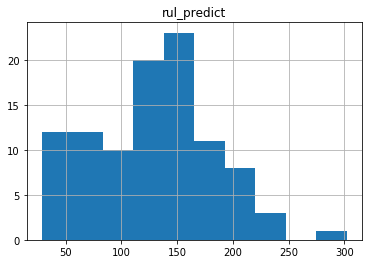

In [296]:
#Analisando também a distribuição do RUL de todos os meus ativos na base de teste
last_rul = df_test_pred.groupby('asset_id')['rul_predict'].max().reset_index()
last_rul.hist('rul_predict')

In [300]:
#Por fim, exibindo um dataset com a identificação dos ativos e seu respectivo RUL atual
last_rul[50:100]

asset_id  rul_predict
50        51          143
51        52          188
52        53          163
53        54          120
54        55          112
55        56          135
56        57          159
57        58          175
58        59           93
59        60          146
60        61          158
61        62          231
62        63          154
63        64          167
64        65           70
65        66          146
66        67           70
67        68          186
68        69           53
69        70          151
70        71           67
71        72          130
72        73          111
73        74          136
74        75           87
75        76          204
76        77          161
77        78           71
78        79          100
79        80          132
80        81          212
81        82          161
82        83           72
83        84          171
84        85           33
85        86          109
86        87           55
87        88           67
88        89          176
89        90          145
90        91          233
91        92          149
92        93          243
93        94          132
94        95           88
95        96           96
96        97          133
97        98          120
98        99           96
99       100          197

## 6 - Plano de Manutenção dos Ativos

_Seguem algumas sugestões com base no modelo criado:_

* Com esses dados informados, é possível avaliar com certa precisão quais são os ativos que podem falhar nos próximos 20 ciclos, e antecipar a manutenção dos mesmos;
* Com a informação do RUL, além dos 20 ciclos, é possível fazer um planejamento mais longo para mapear a saúde de todos os ativos em funcionamento

## Sugestões para melhoria do modelo:
* Avaliar a performance de outros algoritmos nesse tipo de predição
* Evoluir o modelo com técnicas de tunagem como Grid Search ou RPO, também com intuito de melhorar a performance
* Excluir atributos de baixa importância
* Enriquecer o modelo com outras variáveis de classificação do RUL, tais como Idade do Ativo, Intensidade do Uso e Nível de Manutenção 

## Referências

https://producaoonline.org.br

https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot

https://www.kaggle.com/navjindervirdee/lstm-neural-network-from-scratch

https://www.kaggle.com/darkside92/nasa-turbofan-bak-m-tahmini-lgbm-xgboost

https://www.kaggle.com/nafisur/predictive-maintenance-using-lstm-on-sensor-data

https://medium.com/@RemiStudios/remaining-useful-life-in-predictive-maintenance-ffc91d7e4a97


# Thanks!

![alt text](https://media.giphy.com/media/VbnUQpnihPSIgIXuZv/giphy.gif)